# Соревнования по распознаванию рукописных цифр на Kaggle


In [ ]:
#!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Настраиваем Kaggle API

Загружаем токен аутентификации

In [ ]:
file = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!ls

digit-recognizer.zip  sample_data	     test.csv.zip
kaggle.json	      sample_submission.csv  train.csv.zip


Копируем токен в каталог .kaggle

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json #показываем, где будет храниться

## Загружаем данные с сайта Kaggle

In [ ]:
!kaggle competitions download -c digit-recognizer

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

digit-recognizer.zip  sample_submission.csv  train.csv.zip
sample_data	      test.csv.zip


In [ ]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


##Смотрим на формат данных

Данные для обучения

In [ ]:
!head train.csv

label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel1

Данные для тестирования

In [ ]:
!head test.csv

pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pix

Пример файла с решением

In [ ]:
!head sample_submission.csv

ImageId,Label
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


## Подготовка данных для обучения сети

Загружаем данные для обучения из файла

In [ ]:
train_dataset = np.loadtxt('train.csv', skiprows=1, delimiter=',')

In [ ]:
train_dataset[0:5] #матрица

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Выделяем данные для обучения

In [ ]:
x_train = train_dataset[:, 1:]
# Переформатируем данные в 2D, бэкенд TensorFlow
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

In [ ]:
# форма данных обучающего набора
x_train.shape

(42000, 28, 28, 1)

Нормализуем данные для обучения

In [ ]:
x_train /= 255.0

In [ ]:
# форма одного изображения из обучающего набора
x_train[1].shape

(28, 28, 1)

Выделяем правильные ответы

In [ ]:
y_train = train_dataset[:, 0]

In [ ]:
y_train[:5]

array([1., 0., 1., 4., 0.])

Преобразуем ответы в формат one hot encoding

In [ ]:
y_train = utils.to_categorical(y_train)

In [ ]:
y_train[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Разделяем набор данных на две части: для обучения (X_Train, Y_train) и проверки (X_val, Y_val)

In [ ]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

In [ ]:
# форма данных обучающего набора
X_train.shape

(37800, 28, 28, 1)

In [ ]:
X_val.shape

(4200, 28, 28, 1)

In [ ]:
Y_train.shape

(37800, 10)

In [ ]:
Y_val.shape

(4200, 10)

#Создаем генератор для расширения данных во время обучения
Расширение данных реализуется  в процессе обучения за счет трансформации имеющихся данных.

Для этого при обучении модели используется метод flow, который применяется к данным в datagen, которые, в свою очередь, мы пропускаем через генератор ImageDataGenerator.
Это так называемое "обучение на лету".

В итоге во время обучения  сеть каждый раз видит разные изображения, трансформированные случайным образом из исходных изображений за счет применения ImageDataGenerator. За счет этого и достигается расширение данных.

Подробнее: см. Франсуа Шолле, 5.2. Расширение данных, с. 169

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.10,
        width_shift_range=0.1,
        height_shift_range=0.1)

In [ ]:
# сохраним в переменную data изображение из обучающего набора X_train
data = X_train[1]

In [ ]:
data.shape

(28, 28, 1)

In [ ]:
# изменение формы - добавим ось на первую позицию для отображения количества изображений
data = np.expand_dims(data, axis=0)

In [ ]:
data.shape

(1, 28, 28, 1)

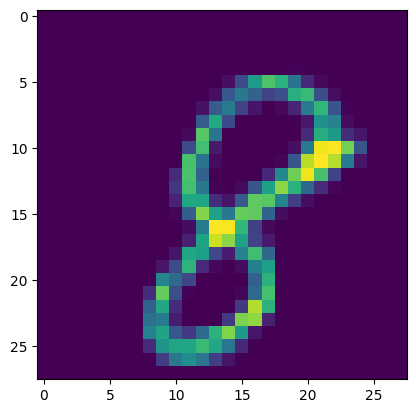

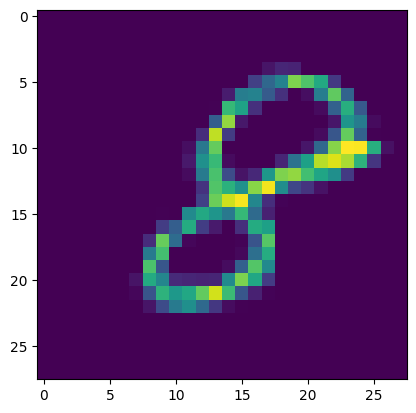

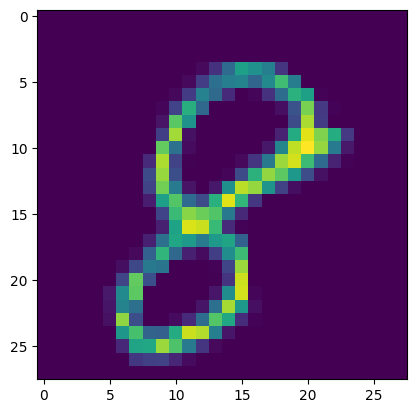

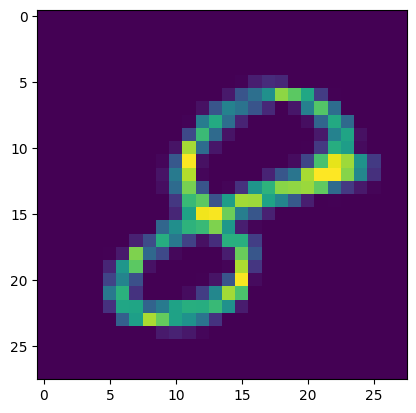

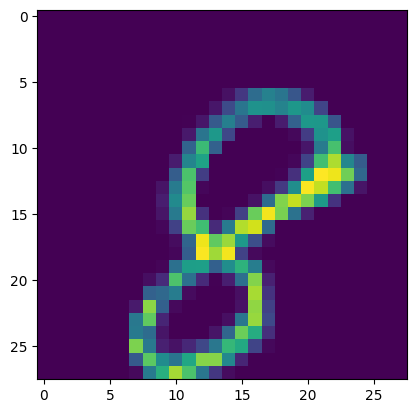

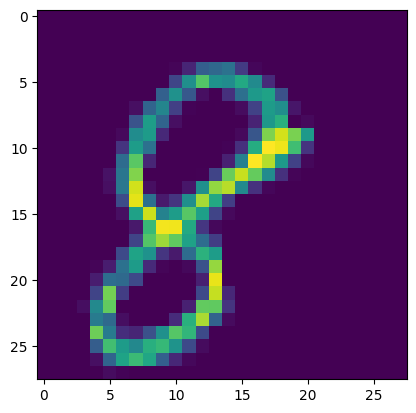

In [ ]:
# продемонстрируем работу ImageDataGenerator на примере одного изображения
i = 0
data = X_train[0]
data = np.expand_dims(data, axis=0)
for batch in datagen.flow(data, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(batch[0][:,:,0])
    i += 1
    if i % 6 == 0:
        break
plt.show()

## Создаем нейронную сеть

**Создаем последовательную модель**

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

**Компилируем сеть**

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

## Обучаем нейронную сеть

In [ ]:
сheckpoint = ModelCheckpoint('mnist-cnn.h5',
                              monitor='val_accuracy',
                              save_best_only=True,
                              verbose=1)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
batch_size=96

In [ ]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                    epochs=30,
                    validation_data=(X_val, Y_val),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=1,
                    callbacks=[сheckpoint, learning_rate_reduction])

Epoch 1/30
393/393 [==============================] - ETA: 0s - loss: 0.4134 - accuracy: 0.8658
Epoch 1: val_accuracy improved from -inf to 0.97857, saving model to mnist-cnn.h5
393/393 [==============================] - 230s 581ms/step - loss: 0.4134 - accuracy: 0.8658 - val_loss: 0.0652 - val_accuracy: 0.9786 - lr: 0.0010
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


393/393 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.9582
Epoch 2: val_accuracy did not improve from 0.97857
393/393 [==============================] - 226s 575ms/step - loss: 0.1397 - accuracy: 0.9582 - val_loss: 0.0709 - val_accuracy: 0.9779 - lr: 0.0010
Epoch 3/30
393/393 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9695
Epoch 3: val_accuracy improved from 0.97857 to 0.98738, saving model to mnist-cnn.h5
393/393 [==============================] - 230s 584ms/step - loss: 0.0983 - accuracy: 0.9695 - val_loss: 0.0377 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 4/30
393/393 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9746
Epoch 4: val_accuracy improved from 0.98738 to 0.99000, saving model to mnist-cnn.h5
393/393 [==============================] - 226s 576ms/step - loss: 0.0856 - accuracy: 0.9746 - val_loss: 0.0349 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 5/30
393/393 [==============================] - ETA:

In [ ]:
model.load_weights('mnist-cnn.h5')

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
history.history['val_accuracy']

[0.9785714149475098,
 0.9778571724891663,
 0.9873809814453125,
 0.9900000095367432,
 0.9926190376281738,
 0.9902380704879761,
 0.9892857074737549,
 0.9938095211982727,
 0.9904761910438538,
 0.9928571581840515,
 0.9933333396911621,
 0.994523823261261,
 0.9928571581840515,
 0.9933333396911621,
 0.9954761862754822,
 0.9957143068313599,
 0.993571400642395,
 0.9942857027053833,
 0.9950000047683716,
 0.9952380657196045,
 0.9947618842124939,
 0.9950000047683716,
 0.9952380657196045,
 0.9947618842124939,
 0.9952380657196045,
 0.9950000047683716,
 0.9952380657196045,
 0.9952380657196045,
 0.9954761862754822,
 0.9950000047683716]

In [ ]:
max(history.history['val_accuracy'])

0.9957143068313599

## Визуализация качества обучения


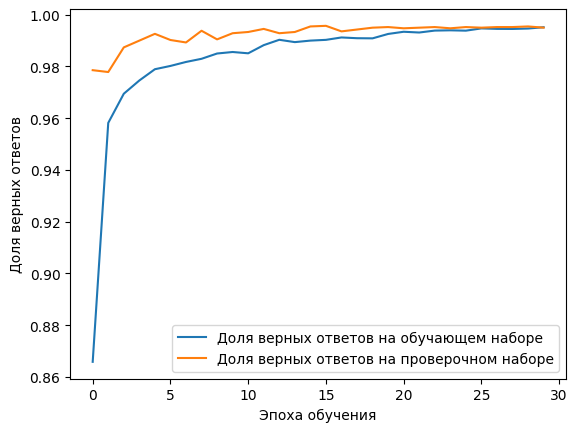

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем данные для распознавания

In [ ]:
test_dataset = np.loadtxt('test.csv', skiprows=1, delimiter=",")

In [ ]:
test_dataset[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
x_test = test_dataset.reshape(test_dataset.shape[0], 28, 28, 1)

Нормализация данных

In [ ]:
x_test = x_test / 255.0

## Запускаем распознавание рукописных цифр из тестового набора данных

In [ ]:
predictions = model.predict(x_test)

875/875 [==============================] - 43s 49ms/step


In [ ]:
predictions[:3]

array([[1.20630316e-16, 7.41182696e-14, 9.99999940e-01, 2.27304781e-14,
        6.73517503e-13, 1.38305312e-18, 5.80032744e-17, 5.23953320e-12,
        7.23040266e-14, 4.82776042e-15],
       [9.99999464e-01, 7.17068210e-11, 1.13774696e-07, 9.87636084e-10,
        3.86561033e-10, 1.67356280e-08, 4.62139234e-08, 7.69500463e-10,
        1.20340673e-07, 2.27902845e-07],
       [2.53493537e-09, 1.57461457e-08, 1.30408793e-07, 1.93068701e-07,
        9.84159997e-05, 2.59030326e-08, 1.40670600e-10, 1.69111354e-06,
        1.75545892e-06, 9.99897659e-01]], dtype=float32)

Преобразуем результаты распознавания из формата one hot encoding в цифры

In [ ]:
predictions = np.argmax(predictions, axis=1)

In [ ]:
predictions[:3]

array([2, 0, 9])

### Готовим файл с решением для Kaggle

In [ ]:
out = np.column_stack((range(1, predictions.shape[0]+1), predictions))

In [ ]:
out[:5]

array([[1, 2],
       [2, 0],
       [3, 9],
       [4, 0],
       [5, 3]])

Записываем результаты в файл

In [ ]:
np.savetxt('submission.csv', out, header="ImageId,Label",
            comments="", fmt="%d,%d")

In [ ]:
!head submission.csv

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


## Отправляем решение на соревнование

In [ ]:
!kaggle competitions submit -c digit-recognizer -m "Submition from Colab" -f submission.csv

100% 208k/208k [00:00<00:00, 625kB/s]  
Successfully submitted to Digit Recognizer

# ***Рекомендуем почитать
Как правильно «фармить» Kaggle
https://habr.com/ru/company/ods/blog/426227/
